# Creating a Multi-Classification Neural Network in Python


## Data Set
https://www.kaggle.com/datasets/mrsimple07/obesity-prediction

In [20]:
import pandas as pd
data = pd.read_csv("obesity_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1000 non-null   int64  
 1   Gender                 1000 non-null   object 
 2   Height                 1000 non-null   float64
 3   Weight                 1000 non-null   float64
 4   BMI                    1000 non-null   float64
 5   PhysicalActivityLevel  1000 non-null   int64  
 6   ObesityCategory        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [21]:
# Check for missing values
data.isnull().sum()

Age                      0
Gender                   0
Height                   0
Weight                   0
BMI                      0
PhysicalActivityLevel    0
ObesityCategory          0
dtype: int64

In [22]:
# Check for duplicate values
data.duplicated().sum()

0

In [23]:
data.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


Great! Our data does not contain any errors. Now we need to make sure the data is unbiased.

<Figure size 1000x1300 with 0 Axes>

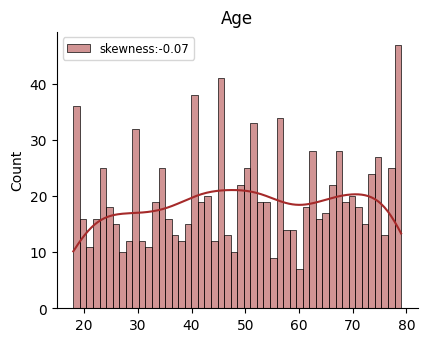

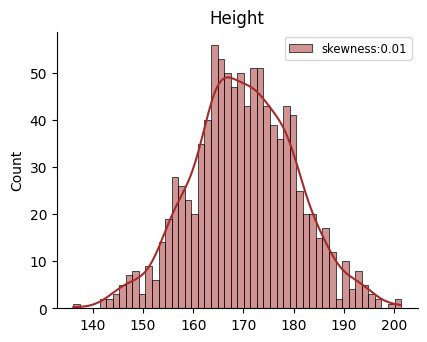

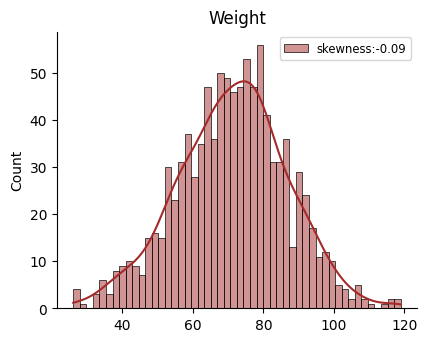

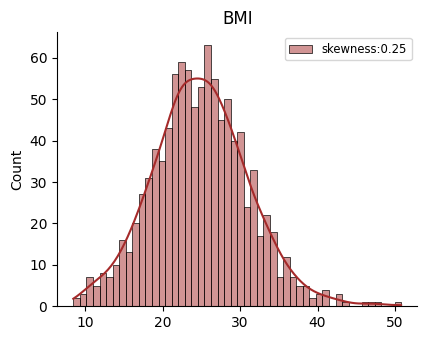

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
non_binary_data = data.select_dtypes(include= ["int64", "float64"]).columns
plt.figure(figsize=(10,13))
#non_binary_data contains physical activity level which is unsuitable for a histogram
for i in non_binary_data[:-1]:
    sns.displot(data[i], color="brown", bins=50, label=f"skewness:{data[i].skew().round(2)}",kde = True,height=3.5,aspect=1.25)
    plt.title(f"{i}"), plt.xlabel("")
    plt.legend(fontsize="small")
plt.tight_layout()
plt.show()

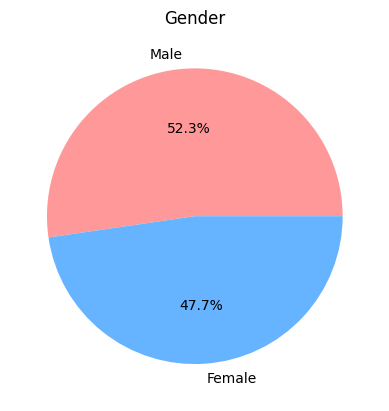

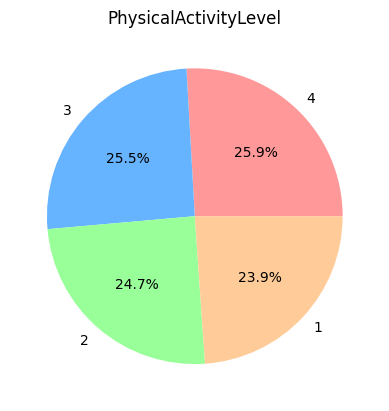

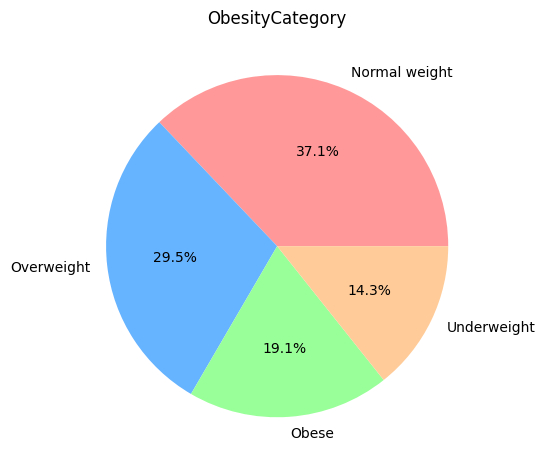

In [26]:
for i in ["Gender", "PhysicalActivityLevel", "ObesityCategory"]:
    fig,ax = plt.subplots()
    ax.set_title(f"{i}")
    ax.pie(data[i].value_counts().values,labels=data[i].value_counts().index,colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],autopct='%1.1f%%')
plt.tight_layout()
plt.show()

Our data appears to be unbiased

## Data Preparation

The data contains 1000 samples with 7 features. However, some features are strings while others are floats so we need to turn all features to type float

In [28]:
import numpy as np
data = np.array(data)
m, n = data.shape

data[data == "Male"] = 0
data[data == "Female"] = 1
data[data == "Underweight"] = 0
data[data == "Normal weight"] = 1
data[data == "Overweight"] = 2
data[data == "Obese"] = 3

Great! But each feature has their own "scale". For example BMI values range from 8.5 to 50.8 while Height ranges from 136 to 201 cm. This is unsuitable for machine learning for a few reasons.

1. Prevents a feature with a larger scale to dominate the weight adjustments
2. Prevents overflows (Softmax function)
3. Helps gradient descent to converge faster

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = data
X_data = data[:, :-1]
#changing data from object to float
X_data = X_data.astype(float)
#scale data
X_data = scaler.fit_transform(X_data)
X_train = X_data[:800, :]
X_test = X_data[800:960, :]
X_validation = X_data[960:1000, :]

Y_data = data[:, -1]
Y_data = Y_data.astype(int)
Y_train = Y_data[:800]
Y_test = Y_data[800:960]
Y_validation = Y_data[960:1000]

# One Vs All One Hot Encoding

In [ ]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y


Y_train_one_hot = one_hot(Y_train)
Y_test_one_hot = one_hot(Y_test)
Y_validation_one_hot = one_hot(Y_validation)